# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [10]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import cv2
import scipy
import math
import random

from pathlib import Path
import glob
from collections import Counter
from PIL import Image
import re
from itertools import batched

from src import data
import cv2
import torch
from torchvision.transforms import v2

import os
from glob import glob

from tqdm import tqdm

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 10
})

from sklearn.model_selection import train_test_split

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

In [26]:
data_dir = Path('./data/CytoSense')
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations, len(annotations)

def to_latin(key):
    key_new = key.replace('-', '_')
    key_new = key_new.replace(' ', '_')
    pieces = key_new.split('_')
    return ' '.join(pieces)

def to_latex(name):
    pieces = name.split(' ')
    if len(pieces) == 1:
        title = f'\\textit{{{name}}}'
    else:
        title = ('\\textit{{{}}} ' * len(pieces)).format(*pieces)[:-1]
    title = title.replace('\\textit{sp}', 'sp.')
    title = title.replace('\\textit{like}', 'like')
    title = title.replace('\\textit{single}', 'single')
    title = title.replace('\\textit{coiled}', 'coiled')
    title = title.replace('\\textit{Small}', 'Small')
    title = title.replace('\\textit{centric}', 'centric')
    return title

Counter({'Cryptophyceae-Teleaulax': 2594, 'Aphanizomenon_flosaquae': 1658, 'Eutreptiella_sp': 1015, 'Pyramimonas_sp': 839, 'Chroococales': 836, 'Heterocapsa_rotundata': 329, 'Monoraphidium_contortum': 253, 'Dinophyceae': 218, 'Oscillatorialles': 203, 'Dolichospermum-Anabaenopsis-coiled': 156, 'Chrysochromulina': 146, 'Cryptomonadales': 122, 'Small centric': 116, 'Pennales': 101, 'Oocystis_sp': 91, 'Dolichospermum_Anabaenopsis': 78, 'Ciliata': 66, 'Euglenophyceae': 66, 'Pseudopedinella_sp': 55, 'Heterocapsa_triquetra': 53, 'Nodularia_spumigena': 49, 'Ceratoconeis closterion': 43, 'Gymnodinium_like': 41, 'Chaetoceros_sp': 35, 'Cyclotella_choctawhatcheeana': 32, 'Centrales_sp': 31, 'Snowella-Woronichinia': 27, 'Heterocyte': 17, 'Chlorococcales': 16, 'Katablepharis_remigera': 14, 'Skeletonema_marinoi': 13, 'Nitzschia_paleacea': 11, 'Hemiselmis': 10, 'Mesodinium_rubrum': 8, 'Gymnodiniales': 4, 'Chaetoceros_sp_single': 3, 'Licmophora': 3, 'Dinophysis_acuminata': 1})


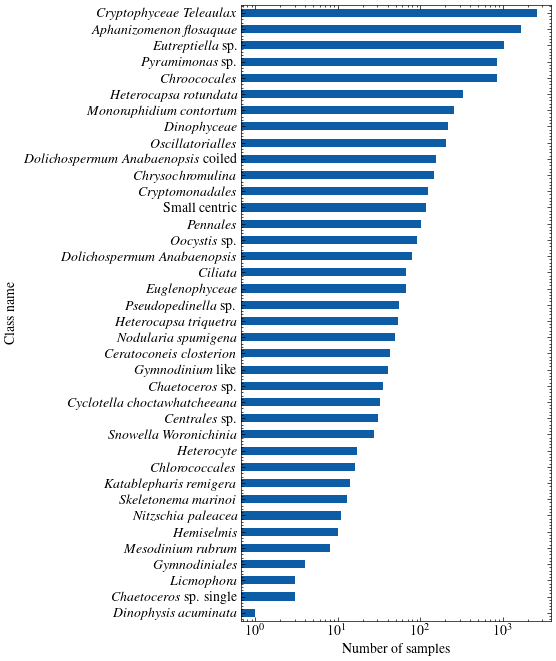

In [29]:
counter = Counter(annotations['class'])
print(counter)

for key in list(counter.keys()):
    title = to_latex(to_latin(key))
    counter[title] = counter[key]
    if title != key:
        del counter[key]


df = pd.DataFrame(
    data=counter.values(),
    index=counter.keys(),
).sort_values(0)

fig, ax = plt.subplots(figsize=(4, 8))

df.plot(kind='barh', legend=False, ax=ax)

ax.set_xlabel('Number of samples')
ax.set_ylabel('Class name')

# plt.savefig(f'figures/sample_counts.pdf')
ax.set_xscale('log')
plt.show()

In [34]:
annot1 = pd.read_csv('./data/CytoSense/annotations.csv')
annot2 = pd.read_csv('./data/FASTVISION-plus/annotations.csv')

counter1 = Counter(annot1['class'])
counter2 = Counter(annot2['class'])

for key in list(counter1.keys()):
    title = to_latin(key)
    counter1[title] = counter1[key]
    if title != key:
        del counter1[key]

for key in list(counter2.keys()):
    title = to_latin(key)
    counter2[title] = counter2[key]
    if title != key:
        del counter2[key]

df1 = pd.DataFrame(
    data=counter1.values(),
    index=counter1.keys(),
    columns=['Sea']
)

df2 = pd.DataFrame(
    data=counter2.values(),
    index=counter2.keys(),
    columns=['Lab'],
)

# # Concatenate along rows (axis=0)
result = pd.merge(df1, df2, left_index=True, right_index=True, how="outer")
result.index = result.index.map(to_latex)
print(result.shape)
print(result.to_latex(float_format='%.0f').replace('NaN', '\\xmark'))

(60, 2)
\begin{tabular}{lrr}
\toprule
 & Sea & Lab \\
\midrule
\textit{Aphanizomenon} \textit{flosaquae} & 1658 & 926 \\
\textit{Apocalathium} \textit{malmogiense} & \xmark & 936 \\
\textit{Biecheleria} \textit{baltica} & \xmark & 685 \\
\textit{Centrales} sp. & 31 & \xmark \\
\textit{Ceratoconeis} \textit{closterion} & 43 & \xmark \\
\textit{Chaetoceros} sp. & 35 & \xmark \\
\textit{Chaetoceros} sp. single & 3 & \xmark \\
\textit{Chlorococcales} & 16 & \xmark \\
\textit{Chroococales} & 836 & \xmark \\
\textit{Chroomonas} \textit{vectensis} & \xmark & 645 \\
\textit{Chrysochromulina} & 146 & \xmark \\
\textit{Chrysochromulina} \textit{simplex} & \xmark & 543 \\
\textit{Chrysotila} \textit{roscoffensis} & \xmark & 701 \\
\textit{Ciliata} & 66 & \xmark \\
\textit{Cryptomonadales} & 122 & \xmark \\
\textit{Cryptophyceae} \textit{Teleaulax} & 2594 & \xmark \\
\textit{Cyclotella} \textit{choctawhatcheeana} & 32 & \xmark \\
\textit{Diacronema} \textit{ennorea} & \xmark & 594 \\
\textit{Diacr

### Visualization

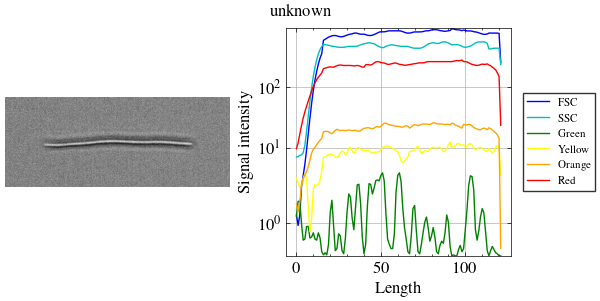

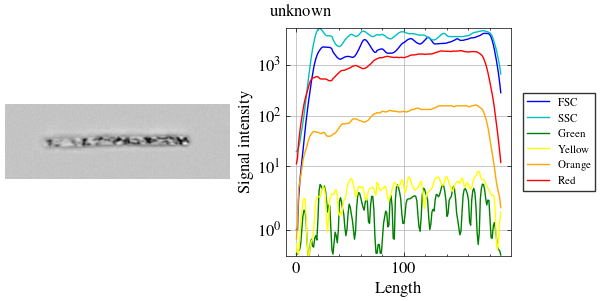

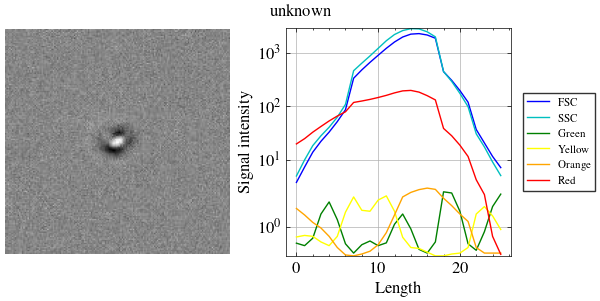

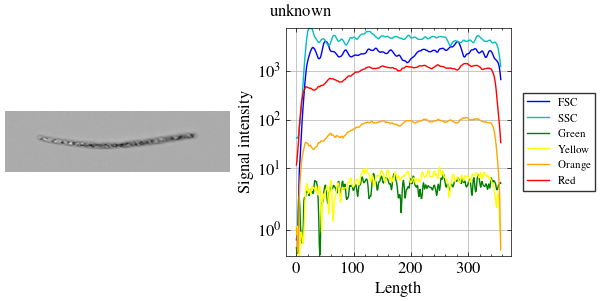

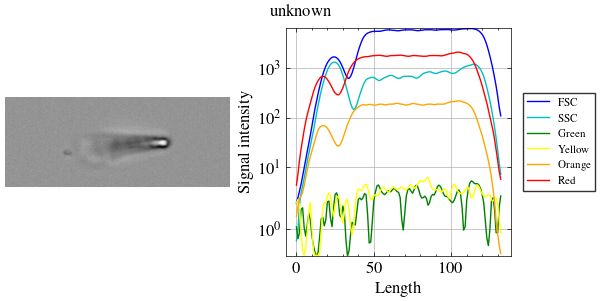

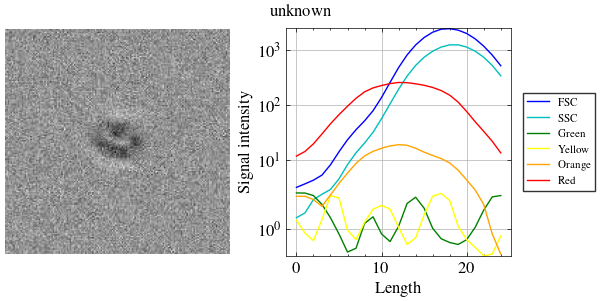

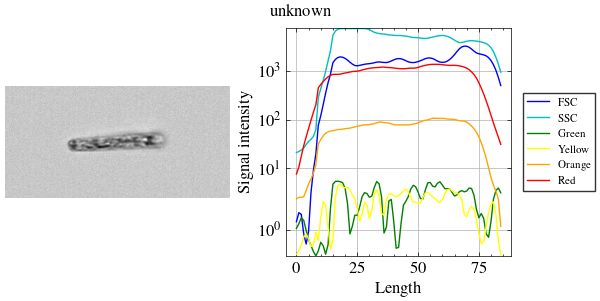

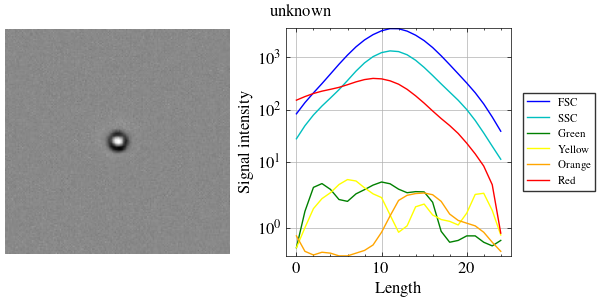

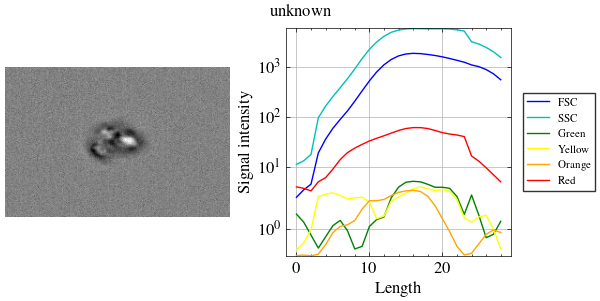

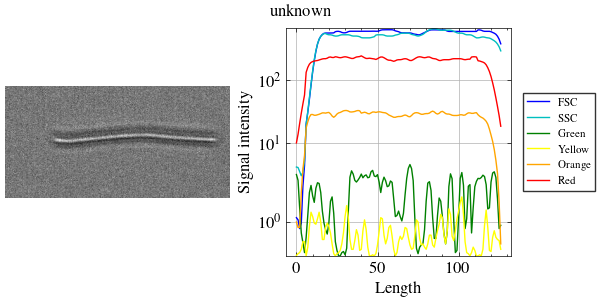

In [5]:
np.random.seed(1)


def visualize(sample):
    image = np.array(Image.open(data_dir / f"{sample.image}"))
    profile = pd.read_csv(data_dir / f"{sample.profile}")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image, 'gray')
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.4, 0.5), fontsize=8)
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Signal intensity')
    ax2.set_yscale('symlog')
    ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(6, 3)

    name = sample['class']
    title = to_latin(name)
    
    plt.grid()
    plt.suptitle(title, fontsize=12)
    # plt.savefig(f'figures/{sample['class']}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(10).iterrows():
    visualize(sample)



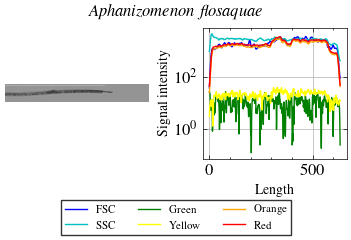

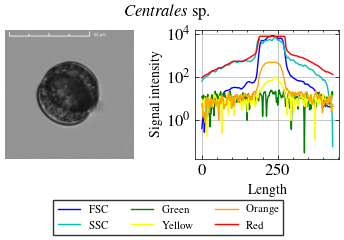

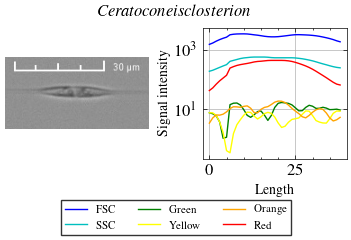

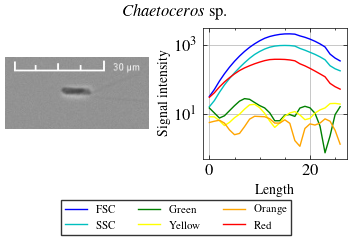

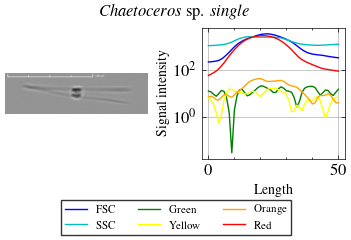

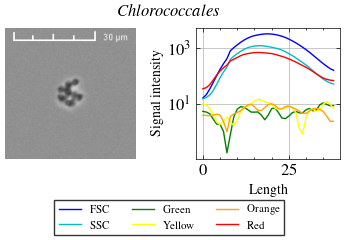

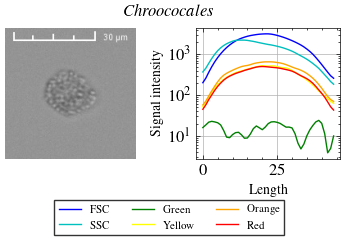

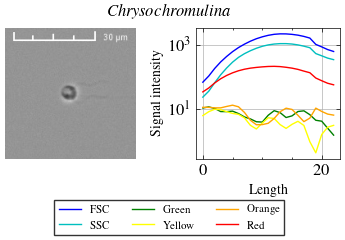

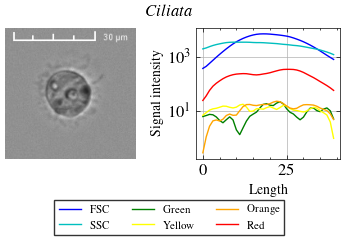

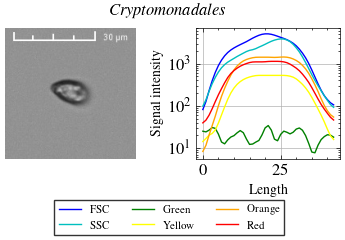

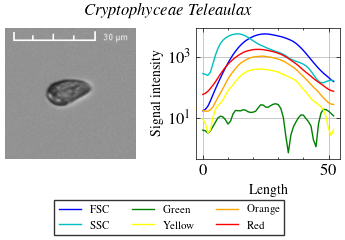

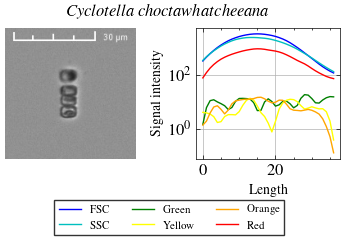

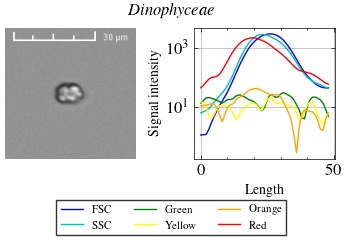

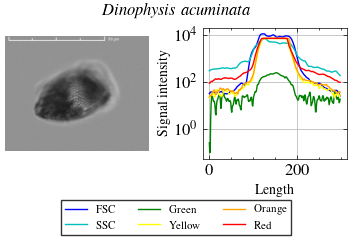

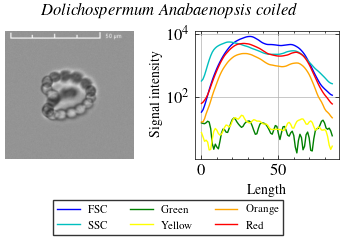

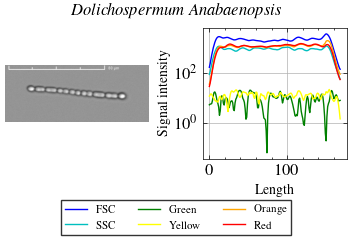

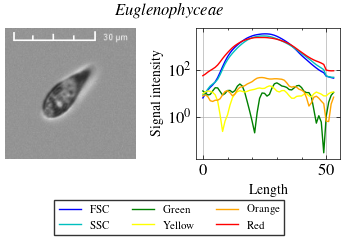

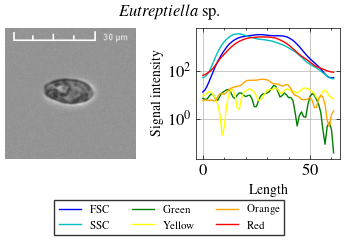

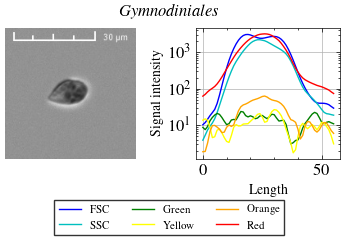

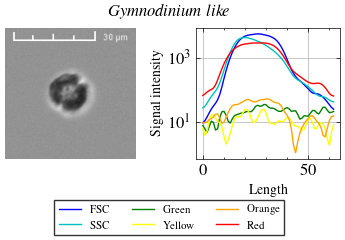

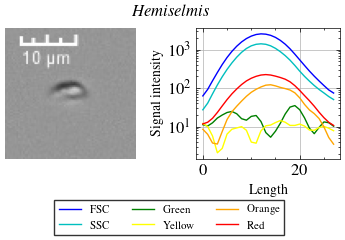

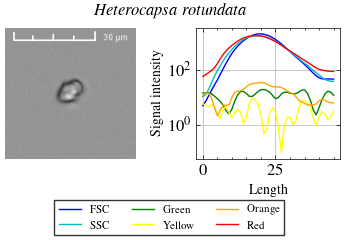

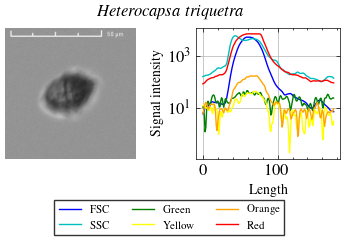

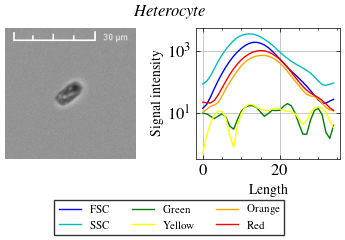

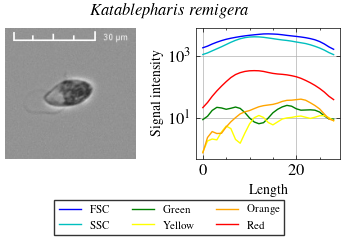

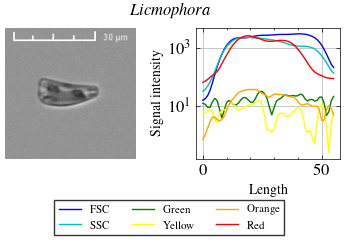

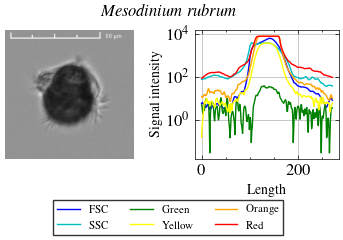

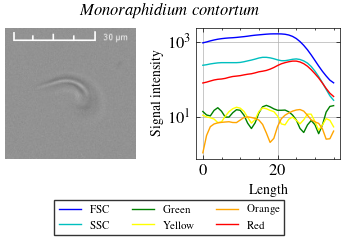

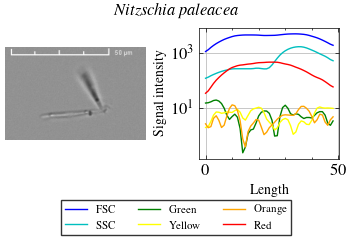

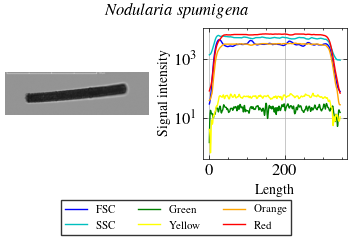

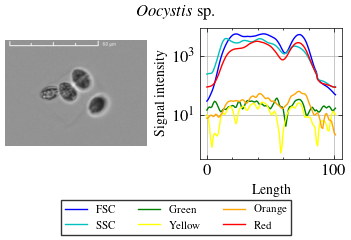

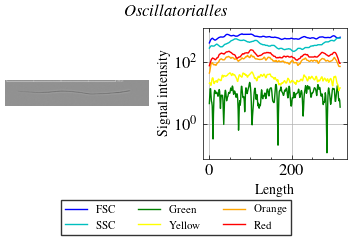

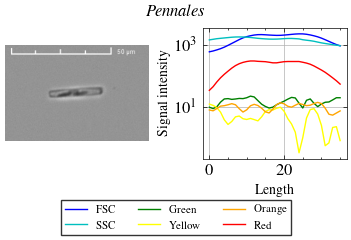

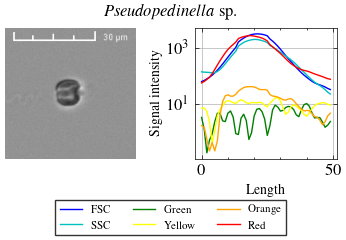

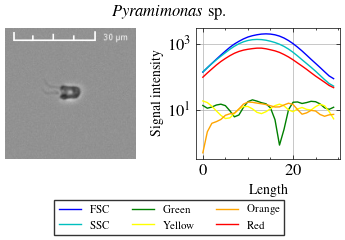

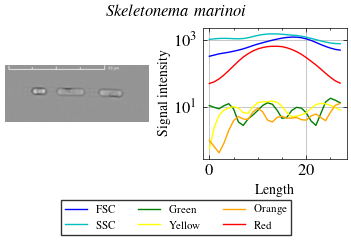

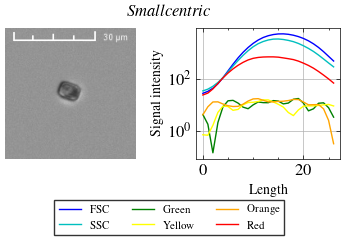

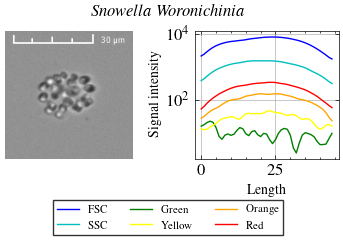

In [5]:
def visualize(sample):
    image = np.array(Image.open(data_dir / f"{sample.image}"))
    profile = pd.read_csv(data_dir / f"{sample.profile}")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)), legend=None)
    fig.legend(loc=8, ncols=3, frameon=True, edgecolor='k', fancybox=False, fontsize=8, bbox_to_anchor=(.5, -.2))
    ax2.set_xlabel('Length', fontsize=10)
    ax2.set_ylabel('Signal intensity', fontsize=10)
    ax2.set_yscale('log')
    # ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(3.5, 2)
    
    title = to_latin(name) 
    
    plt.grid()
    plt.suptitle(title, fontsize=12)
    plt.savefig(f'figures/small_{sample['class']}.pdf')
    plt.show()

for name in annotations['class'].unique():
    for _, sample in annotations[annotations['class'] == name].sample(1).iterrows():
        visualize(sample)



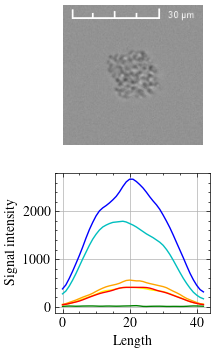

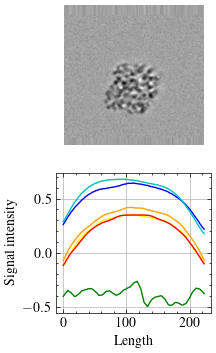

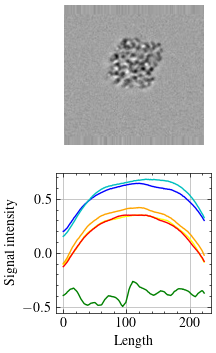

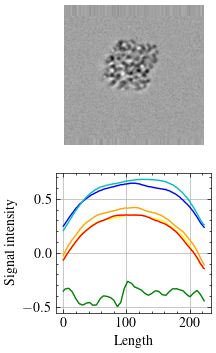

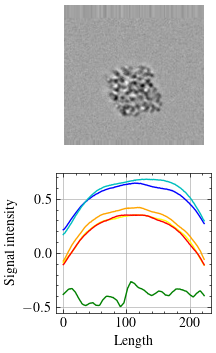

In [46]:
from src import data
import cv2
import torch

sample = annotations.iloc[2000]

image = Image.open(data_dir / sample.image).convert('RGB')
profile = np.loadtxt(data_dir / sample.profile, delimiter=',', skiprows=1)  
profile = torch.tensor(profile)

img_tr = data.ImageTransformTrain()
prf_tr = data.ProfileTransformTrain(224)
pair_tr = data.PairAugmentation()

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
for feature, color in zip(profile.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Length', fontsize=10)
ax2.set_ylabel('Signal intensity', fontsize=10)
plt.grid()
plt.savefig(f'figures/augment_{sample['class']}_orig.pdf')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(img_tr(image)[0], cmap='gray')
ax1.set_axis_off()
for feature, color in zip(prf_tr(profile).T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Length', fontsize=10)
ax2.set_ylabel('Signal intensity', fontsize=10)
plt.grid()
plt.savefig(f'figures/augment_{sample['class']}_proc.pdf')

for i in range(3):
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
    foo, bar = pair_tr(img_tr(image), prf_tr(profile))
    ax1.imshow(foo[0], cmap='gray')
    ax1.set_axis_off()
    for feature, color in zip(bar.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
        ax2.plot(feature, color=color)
    ax2.set_xlabel('Length', fontsize=10)
    ax2.set_ylabel('Signal intensity', fontsize=10)
    plt.grid()
    plt.savefig(f'figures/augment_{sample['class']}_{i}.pdf')


<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_33741/3386004030.py:8: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')


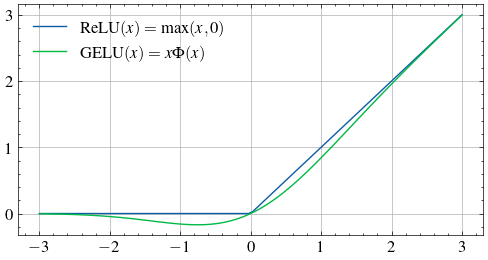

In [11]:
import torch
from torch.nn.functional import relu, gelu

fig, ax = plt.subplots(figsize=(6, 3))

x = torch.linspace(-3, 3, 100)
ax.plot(x, relu(x), label='ReLU$(x) =$ max$(x, 0)$')
ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')

ax.legend()
ax.grid()
fig.savefig('figures/relugelu.pdf')

In [93]:
lab = pl.read_csv('./data/FASTVISION-plus/annotations.csv')
small = pl.read_csv('./data/CytoSense/annotations.csv')
large = pl.read_csv('./data/CS_pulse-shape_data_forLUT/CS_103_Uto2024/annotations.csv')

def join(df, column, prefix):
    return df.with_columns((
        pl.col(column)
        .map_elements(lambda x: f'{prefix}/{x}', return_dtype=pl.String)
        .alias(f'{column}_full')
    ))

lab = join(lab, 'image', './data/FASTVISION-plus')
lab = join(lab, 'profile', './data/FASTVISION-plus')

small = join(small, 'image', './data/CytoSense')
small = join(small, 'profile', './data/CytoSense')

large = join(large, 'image', './data/CS_pulse-shape_data_forLUT/CS_103_Uto2024')
large = join(large, 'profile', './data/CS_pulse-shape_data_forLUT/CS_103_Uto2024')

# annots = pl.concat((lab, small, large))
annots = pl.concat((small, large))
# annots = pl.concat((lab,))

image_vals = np.concatenate([cv2.imread(file, cv2.IMREAD_GRAYSCALE).ravel() for file in tqdm(annots['image_full'])])
profile_vals = pl.concat([pl.read_csv(file) for file in tqdm(annots['profile_full'])])

  0%|          | 0/42283 [00:00<?, ?it/s]

100%|██████████| 42283/42283 [00:08<00:00, 4750.07it/s]


In [94]:
image_vals, profile_vals

(array([151, 147, 144, ..., 157, 157, 155],
       shape=(2448022400,), dtype=uint8),
 shape: (3_945_731, 6)
 ┌────────────┬────────────┬───────────┬────────┬────────┬────────────┐
 │ FSC        ┆ SSC        ┆ Green     ┆ Yellow ┆ Orange ┆ Red        │
 │ ---        ┆ ---        ┆ ---       ┆ ---    ┆ ---    ┆ ---        │
 │ f64        ┆ f64        ┆ f64       ┆ f64    ┆ f64    ┆ f64        │
 ╞════════════╪════════════╪═══════════╪════════╪════════╪════════════╡
 │ 55.330002  ┆ 773.299988 ┆ 9.917     ┆ 5.75   ┆ 41.0   ┆ 46.330002  │
 │ 77.0       ┆ 904.0      ┆ 15.53     ┆ 6.281  ┆ 47.0   ┆ 55.75      │
 │ 120.5      ┆ 1160.0     ┆ 17.559999 ┆ 6.469  ┆ 61.25  ┆ 79.75      │
 │ 186.0      ┆ 1520.0     ┆ 14.44     ┆ 5.719  ┆ 86.25  ┆ 120.5      │
 │ 278.0      ┆ 1980.0     ┆ 15.44     ┆ 5.688  ┆ 128.5  ┆ 178.5      │
 │ …          ┆ …          ┆ …         ┆ …      ┆ …      ┆ …          │
 │ 259.100006 ┆ 323.0      ┆ 1.438     ┆ 3.688  ┆ 3.031  ┆ 363.0      │
 │ 164.399994 ┆ 209.0      

In [105]:
np.log(profile_vals.max())

array([[9.60575514, 8.92105702, 8.92105702, 8.92105702, 8.92105702,
        8.92105702]])

In [107]:
print('ceil=[', ', '.join(map(lambda x: f'{x:.4f}', np.log(profile_vals.max())[0])), ']', sep='')

ceil=[9.6058, 8.9211, 8.9211, 8.9211, 8.9211, 8.9211]


In [117]:
torch.FloatTensor([9.6058, 8.9211, 8.9211, 8.9211, 8.9211, 8.9211])

tensor([9.6058, 8.9211, 8.9211, 8.9211, 8.9211, 8.9211])

In [98]:
np.log(14850)

np.float64(9.605755144230846)

In [87]:
foo = image_vals.astype(np.float32) / 255
print(f'mean=[{foo.mean():.4f}]')
print(f'std=[{foo.std():.4f}]')

mean=[0.6136]
std=[0.0938]


In [102]:
bar = np.log(profile_vals + 1)
print('mean=[', ', '.join(map(lambda x: f'{x:.4f}', bar.mean(0))), ']', sep='')
print('std=[', ', '.join(map(lambda x: f'{x:.4f}', bar.std(0))), ']', sep='')

mean=[6.8749, 7.2139, 1.6094, 1.9681, 3.4522, 5.9750]
std=[1.8682, 1.6612, 0.8306, 1.3525, 2.0576, 1.7626]


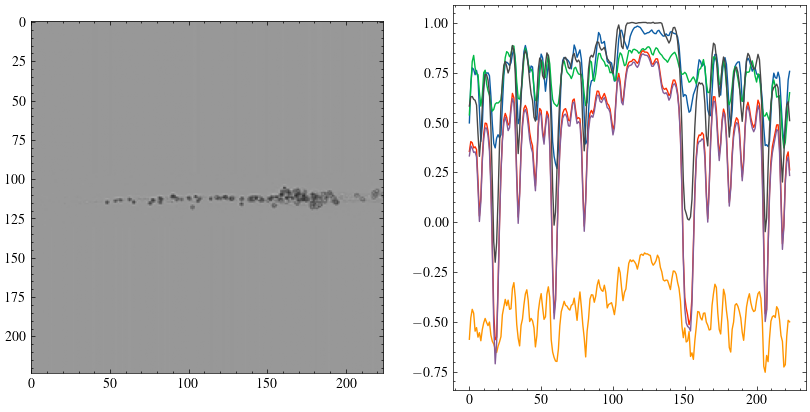

In [47]:
from src.data import *
import matplotlib.pyplot as plt

dataset = MultiSet(
    Path('./data/CS_pulse-shape_data_forLUT/CS_103_Uto2024/annotations.csv'),    
    ImageTransformTrain(),
    ProfileTransformTrain(224),
    PairAugmentation(),
)

sample = dataset[4]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample['image'].permute(1, 2, 0), cmap='gray', vmin=-1, vmax=1)
ax[1].plot(sample['profile'])

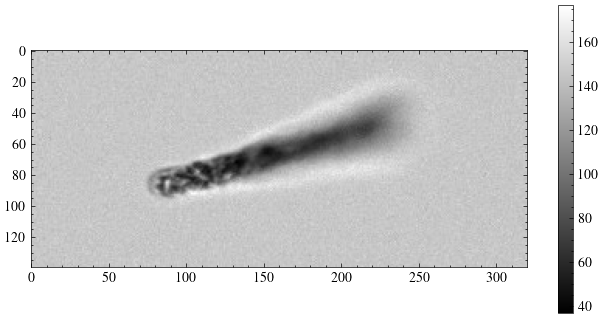

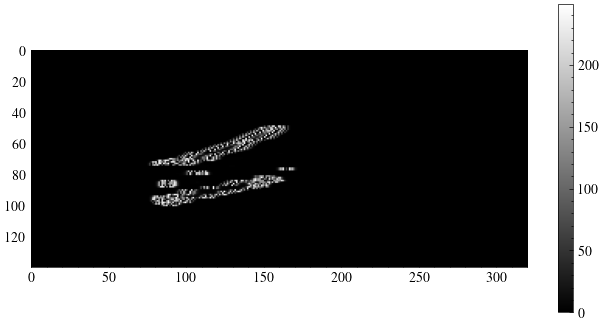

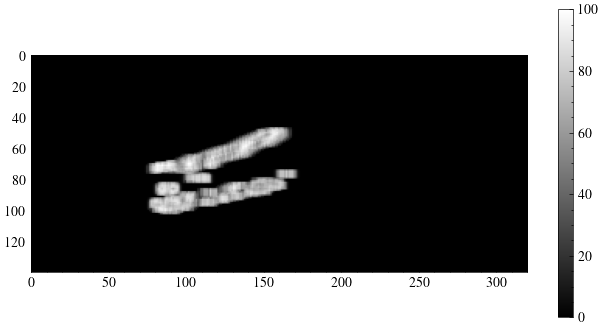

In [49]:
import scipy.ndimage


file_name = 'data/CytoSense/Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-09 13h10_Cropped_With_Scalebar_461.jpg'

img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
img = img[20:]

plt.figure(figsize=(8, 4))
plt.imshow(img, cmap='gray')
plt.colorbar()

laplacian = scipy.ndimage.gaussian_laplace(img, 3)**2
# laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min())


plt.figure(figsize=(8, 4))
plt.imshow(laplacian, cmap='gray')
plt.colorbar()

def filt(window):
    return window.std()

stds = scipy.ndimage.generic_filter(laplacian, filt, 5)

plt.figure(figsize=(8, 4))
plt.imshow(stds, cmap='gray')
plt.colorbar()